The purpose of this note book is to quickly impliment a version of the xylem imparment, growth and death described in section 2.6 of [A.Pahchalis et al 2023](https://pubmed.ncbi.nlm.nih.gov/37962234/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from profit_optimisation_model.src.vapour_pressure_deficit_calculation import vapour_pressure_deficit
from profit_optimisation_model.src.leaf_air_coupling_model import LeafAirCouplingModel
from profit_optimisation_model.src.rubisco_CO2_and_O_model import RubiscoRates
from profit_optimisation_model.src.electron_transport_rate_model import ElectronTransportRateModel

#-- Conductance models --
from profit_optimisation_model.src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials
from profit_optimisation_model.src.HydraulicConductanceModels.DynamicModels.capped_conductance_model import CappedHydraulicConductanceModel
from profit_optimisation_model.src.HydraulicConductanceModels.DynamicModels.A_Pachalis_conductance_model import APachalisConductanceModel

# -- Temperature dependency models --
from profit_optimisation_model.src.TemperatureDependenceModels.arrhenius_and_peaked_arrhenius_function import PeakedArrheniusModel, ArrheniusModel
from profit_optimisation_model.src.TemperatureDependenceModels.Q10_temperature_dependence_model import Q10TemperatureDependenceModel
from profit_optimisation_model.src.TemperatureDependenceModels.temperature_dependence_model import LowTemperatureAdjustedModel

# -- Photosynthesis models --
from profit_optimisation_model.src.PhotosynthesisModels.photosynthesis_model import PhotosynthesisModel
from profit_optimisation_model.src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelRubiscoLimitedBonan as PhotosynthesisModelRubiscoLimited
from profit_optimisation_model.src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelElectronTransportLimitedBonan as PhotosynthesisModelElectronTransportLimited

# -- Profit Models --
from profit_optimisation_model.src.ProfitModels.CO2GainModels.CO2_gain_profit_max_model import ProfitMaxCO2GainModel as CO2GainModel
from profit_optimisation_model.src.ProfitModels.HydraulicCostModels.hydraulic_cost_profit_max_model import ProfitMaxHydraulicCostModel as HydraulicCostModel
from profit_optimisation_model.src.ProfitModels.profit_max_model import ProfitMaxModel

from profit_optimisation_model.src.conversions import (magnitude_conversion,
                                                       mole_carbon_to_grams,
                                                       per_day_to_per_second,
                                                       per_second_to_per_half_hour,
                                                       convert_transpiration_rate_to_latent_energy,
                                                       short_wave_to_photosynthetically_active_radiation,
                                                       light_energy_in_joules_to_micro_moles_of_light,
                                                       degrees_kelvin_to_centigrade,
                                                       degrees_centigrade_to_kelvin,
                                                       convert_stomatal_conductance_of_carbon_to_water)

# Introduction
Section 2.6 of [A.Pahchalis et al 2023](https://pubmed.ncbi.nlm.nih.gov/37962234/) describes a conductance model that acounts for not only xylem damage but the growth and death of xylem. In breaf it models the impared conductance of a set of xylem of the same age as the minimum conductance achived over the xylems life span. Growth and death is modeld by tracking the number of xylem of as a function of age, adding newly grown xylem with age zero while removing xylem across ages. The conductance of the whole system can be calculated by intergrating the multiplication of the conductance and number of xylem over their age.

It is important to note that the xylem conductance model in [A.Pahchalis et al 2023](https://pubmed.ncbi.nlm.nih.gov/37962234/) was not designed to work with the profet optimisation model used here. The [A.Pahchalis et al 2023](https://pubmed.ncbi.nlm.nih.gov/37962234/) model was designed to work with the terestrial biosphere model T&C ([Fatichi et al. 2012](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011MS000086)).

# Conductance as a function of age

As described previously, the conductance of a set of xylem of the same age is equal to the minimum conductance during their lifetime. The minimum conductance is that given by the xylem vunrability curve, $k(\psi)$, at the minimum water potential reached during the xylems life time, $\psi_{min}(\alpha, t) = MIN(\psi(t'))$ for $t' \in [t - \alpha, t]$.

$$
k(\alpha, t) = k(\psi_{min}(\alpha, t))
$$

In [2]:
def update_xylem_conductances(xylem_k, current_k):

    # Age the xylem by shifing them one index in historic_k
    xylem_k[1:] = xylem_k[:-1]

    # Set the conductance of the new xylem to the current conductance
    xylem_k[0] = current_k
    
    # Reduce any xylem conductance over the current conductance to the current conductance
    xylem_k = np.clip(xylem_k, 0, current_k)

    return xylem_k

To test this we create a fake set of conductance values over some time period and then iterativly calculate the xylem conductance as a function of age over this time period.

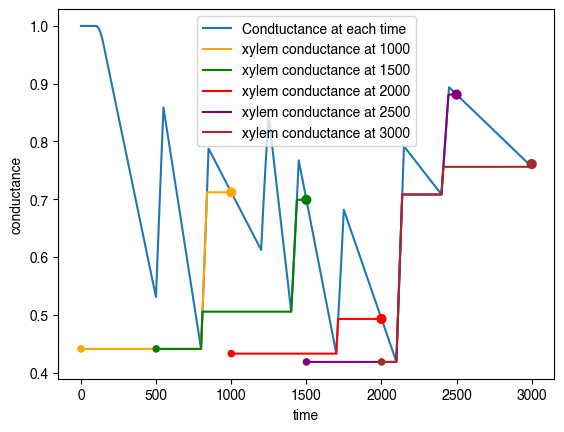

In [3]:
# Number of xylem ages to record conductance and later population over.
num_ages = 1000
ages = np.asarray([i for i in range(num_ages)])
# Array to contain historic conductances.
xylem_k = np.zeros(num_ages)

# Driving data
time_steps = 3001
time = np.linspace(0, time_steps, time_steps)
k_over_t = np.ones(time_steps)

# Create fake conductance with drops in data
k_drops = [[ 100,  500, 1.0, 0.5],
           [ 500,  800, 0.9, 0.4],
           [ 800, 1200, 0.8, 0.6],
           [1200, 1400, 0.9, 0.45],
           [1400, 1700, 0.8, 0.4],
           [1700, 2100, 0.7, 0.4],
           [2100, 2400, 0.8, 0.7],
           [2400, 3000, 0.9, 0.75]
          ]
for drop in k_drops:
    k_over_t[drop[0]:drop[1]] = np.linspace(drop[2], drop[3], drop[1] - drop[0])

# smooth the fake data
window = 50
k_over_t = np.convolve(k_over_t, np.ones(window)/window)[:time_steps]
k_over_t[:window] = 1.0

# Step the model through time and record the results at multiple time steps
snapshot_times = [1000, 1500, 2000, 2500, 3000]
k_over_t_snapshots = np.zeros((len(snapshot_times),num_ages))

current_snapshot_id = 0
for i in range(time_steps):
    xylem_k = update_xylem_conductances(xylem_k, k_over_t[i])

    if(snapshot_times[current_snapshot_id] == i):
        k_over_t_snapshots[current_snapshot_id,:] = xylem_k[:]

        current_snapshot_id += 1

colours = ["orange", "green", "red", "purple", "brown"]

plt.plot(time, k_over_t, label = "Condtuctance at each time", zorder = 0)

for i in range(len(snapshot_times)):
    plt.plot(snapshot_times[i] - ages, k_over_t_snapshots[i,:],
             c = colours[i], label = "xylem conductance at {}".format(snapshot_times[i]), zorder = 1)
    plt.scatter([snapshot_times[i], snapshot_times[i] - ages[-1]], [k_over_t_snapshots[i,0], k_over_t_snapshots[i,-1]],
                s = [40,20], c = colours[i], zorder = 2)

plt.legend()
plt.xlabel("time")
plt.ylabel("conductance")
plt.show()

# Xylem population as a funcction of age

In adition to the conductance we need to trak the number of xylem as a function of age. We define the population as the function $p(\alpha, t)$, where $\alpha$ is the age of the zylem and $t$ is the current time (note, in the paper this is writen as $p_\alpha(t)$). How the population changes as a function of time is described by the following partial differential;

$$
\frac{\partial}{\partial t}p(\alpha, t) = - \frac{\partial}{\partial \alpha} p(\alpha,t) - \mu_x(\alpha,t)p(\alpha,t)
$$

Within this equation the first component, the partial derivative of $p(\alpha,t)$ with respect to age $\alpha$, ages the xylem moving them to higher $\alpha$. The second component makes use of the wood turnover rate $\mu(\alpha,t)$ to kill off or remove xylem from the system. The shape of the turnover rate $\mu(\alpha,t)$ with respect to age, $\alpha$, can be used to preferentialy remove older xylem. Within this work we make $\mu(\alpha,t)$ constant with age, $\alpha$.

The growth of new xylem is modeld by setting the value of the xylem population with age zero to the rate at which xylem are creted, $\lambda(t)$, 

$$
\mu(0,t) = \lambda(t)
$$

In [4]:
def update_xylem_population(xylem_pop, growth_rate, death_rate, time_step):
    
    # Age the xylem by shifing them one index in historic_k
    xylem_pop[1:] = xylem_pop[:-1]

    # Remove dead xylem
    xylem_pop = xylem_pop * ( 1 - death_rate * time_step)

    # Add new xylem
    xylem_pop[0] = growth_rate * time_step

    return xylem_pop

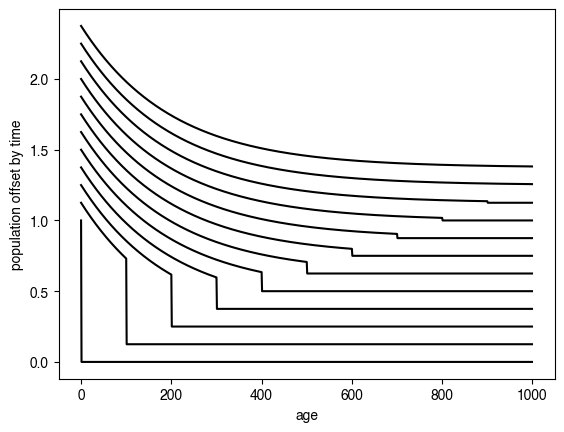

In [5]:
# Create array to hold xylem population
xylem_pop = np.zeros(num_ages)

# Set growth and death rates
growth_rate = 1.
death_rate = 0.005

# Setup record of xylem population snapshots in time
num_snapshots = 12
snapshot_times = [i*100 for i in range(num_snapshots + 1)]
xylem_pop_snapshots = np.zeros((len(snapshot_times),num_ages))

# Time data
time_step = 1.
time_steps = snapshot_times[-1] + 1
time = np.linspace(0, time_steps, time_steps)

current_snapshot_id = 0
for i in range(time_steps):
    xylem_pop = update_xylem_population(xylem_pop, growth_rate, death_rate, time_step)

    if(snapshot_times[current_snapshot_id] == i):
        xylem_pop_snapshots[current_snapshot_id,:] = xylem_pop[:]
    
        current_snapshot_id += 1

for i in range(num_snapshots):
    #plt.plot(ages, np.ones(num_ages) * snapshot_times[i], c = 'grey')
    plt.plot(ages, xylem_pop_snapshots[i,:] + snapshot_times[i]/800, c = 'black')

plt.xlabel("age")
plt.ylabel("population offset by time")
plt.show()

We can see from the plot above that it takes time for the population distribution over age to reach a static shape between timesteps. It is worth noting that the exponential deccay occurs due to the turnpver rate being constant with age. At the start we can see that there are only xylem with age zero. As time progresses these first xylem age, moving the step in the plot to higher ages. From the shape of the final population age distribution it is clear that as age increses the number of serviving xylem drops due to th sapwood turnover rate removing a fraction each timestep.

It is important to note from the graph above that it takes a number of steps for the xylem age distribution to reach a steady state, as such one must let this happen prior to applying the model to data. This is also the point at which the total number of xylem in the system becomes constant.

# Calculating conductance

The conductance at a given point in time is given by the intergration with respect to age of the product of the xylem conductance and populations,

$$
k(t) = \int_0^\infty k(\psi_{min}(\alpha, t)) p(\alpha, t) d\alpha
$$

In [6]:
def conductance(xylem_k, xylem_pop):
    return np.sum(xylem_k * xylem_pop)

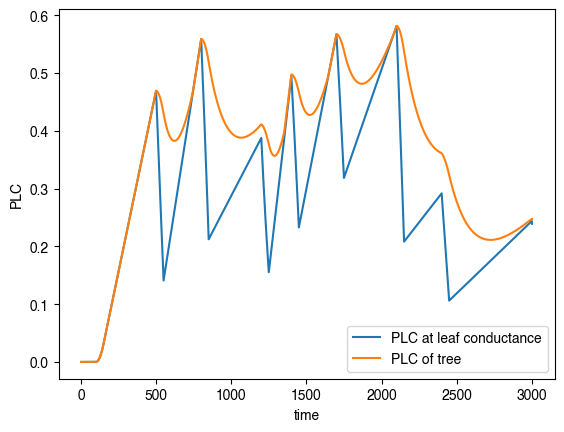

In [7]:
# Number of xylem ages to record conductance and later population over.
num_ages = 1000
ages = np.asarray([i for i in range(num_ages)])
# Array to contain historic conductances.
xylem_k = np.ones(num_ages)

# Driving data
time_steps = 3001
time = np.linspace(0, time_steps, time_steps)
k_leaf_over_t = np.ones(time_steps)

# Create fake conductance with drops in data
k_drops = [[ 100,  500, 1.0, 0.5],
           [ 500,  800, 0.9, 0.4],
           [ 800, 1200, 0.8, 0.6],
           [1200, 1400, 0.9, 0.45],
           [1400, 1700, 0.8, 0.4],
           [1700, 2100, 0.7, 0.4],
           [2100, 2400, 0.8, 0.7],
           [2400, 3000, 0.9, 0.75]
          ]
for drop in k_drops:
    k_leaf_over_t[drop[0]:drop[1]] = np.linspace(drop[2], drop[3], drop[1] - drop[0])

# smooth the fake data
window = 50
k_leaf_over_t = np.convolve(k_leaf_over_t, np.ones(window)/window)[:time_steps]
k_leaf_over_t[:window] = 1.0

# -- Calcualte the conductance --

# full tree conductance over time
tree_k = np.zeros(time_steps)
tree_PLC = np.zeros(time_steps)

current_snapshot_id = 0

for i in range(time_steps):

    # Update the xylem conductance and population logs
    xylem_k = update_xylem_conductances(xylem_k, k_over_t[i])
    xylem_pop = update_xylem_population(xylem_pop, growth_rate, death_rate, time_step)

    # Calculate the conductance
    tree_k[i] = conductance(xylem_k, xylem_pop)

    # Calculate PLC by dividing by the xylem population at that time.
    tree_PLC[i] = tree_k[i] / np.sum(xylem_pop)

# -- Plot the results --
plt.plot(time, 1-k_leaf_over_t, label = "PLC at leaf conductance")
plt.plot(time, 1-tree_PLC, label = "PLC of tree")


plt.legend()
plt.xlabel("time")
plt.ylabel("PLC")
plt.show()

# Adding this to the toy profit optimisation model

A version ofthis hydraulic conductance model has been added to the toy profit optimisation model as the APachalisConductanceModel class.
The code bellow initialises this model along with two others for comparison, a fixed cumulative weibull distribution and a cumulative weibull distribution capped at the previous minimum conductance.

In [8]:
# Creat the vulnerability curve
P50 = -3. # MPa
P88 = -4. # MPa
k_max = 1. # mmol m-2 s-1 MPa-1

# Xylem damage
critical_conductance_loss_fraction = 0.9
xylem_recovery_water_potnetial = 0.
PLC_damage_threshold = 0.0

# Cumulative Weibull
CW_conductance_model = cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                       P50,
                                                                                                       P88,
                                                                                                       0.50,
                                                                                                       0.88,
                                                                                                       critical_conductance_loss_fraction,
                                                                                                       xylem_recovery_water_potnetial,
                                                                                                       PLC_damage_threshold
                                                                                                       )

# Capped cumulaitve Weibull
capped_conductance_model = CappedHydraulicConductanceModel(CW_conductance_model)

# Create the APachalis model
num_gaes = 500
time_step_size = 1. # h
growth_rate = 1.
turnover_rate = 0.5

vulnerability_curve = cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max/10,
                                                                                                      P50,
                                                                                                      P88,
                                                                                                      0.50,
                                                                                                      0.88,
                                                                                                      critical_conductance_loss_fraction,
                                                                                                      xylem_recovery_water_potnetial,
                                                                                                      PLC_damage_threshold
                                                                                                      )

AP_conductance_model = APachalisConductanceModel(vulnerability_curve,
                                                 num_ages,
                                                 time_step_size,
                                                 growth_rate,
                                                 turnover_rate)

Now we create two versions of the full toy model, one with a cumulative weibull distribution for a hydraulic conductance model and the other using the APachalis model described above.

## Hydraulic cost

In [9]:
critical_leaf_water_potential = CW_conductance_model.water_potential_from_conductivity_loss_fraction(0.95)

CW_hydraulic_cost_model = HydraulicCostModel(CW_conductance_model,
                                             critical_leaf_water_potential)

capped_hydraulic_cost_model = HydraulicCostModel(capped_conductance_model,
                                                 critical_leaf_water_potential)

AP_hydraulic_cost_model = HydraulicCostModel(AP_conductance_model,
                                             critical_leaf_water_potential)

## Leaf atmosphere coupling

In [10]:
leaf_air_coupling_model = LeafAirCouplingModel()

## Photosynthesis model

In [11]:
# -- Rubisco limited model --
photosynthesis_rubisco_limited_model = PhotosynthesisModelRubiscoLimited()

# -- Electron transport rate limmited model --
photosynthesis_electron_transport_limited_model = PhotosynthesisModelElectronTransportLimited()

photosynthesis_model = PhotosynthesisModel(photosynthesis_rubisco_limited_model,
                                           photosynthesis_electron_transport_limited_model
                                          )

## CO2 gain

In [12]:
CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

## Profit optimisation models

In [13]:
CW_profit_optimisation_model = ProfitMaxModel(CW_hydraulic_cost_model,
                                              leaf_air_coupling_model,
                                              CO2_gain_model)

capped_profit_optimisation_model = ProfitMaxModel(capped_hydraulic_cost_model,
                                                  leaf_air_coupling_model,
                                                  CO2_gain_model)

AP_profit_optimisation_model = ProfitMaxModel(AP_hydraulic_cost_model,
                                              leaf_air_coupling_model,
                                              CO2_gain_model)

profit_optimisation_models = [CW_profit_optimisation_model,
                              AP_profit_optimisation_model,
                              capped_profit_optimisation_model]

profit_optimisation_model_labels = ["default",
                                    "APachalis",
                                    "capped"]

line_styles = ["-",
               "-",
               "--"]

line_sizes = [6,
              4,
              2]

colours = ['blue',
           'orange',
           'green']

# Testing on constant environmental conditions

Lets test how the A Pachalis model behaves when subject to a set of constant environmental conditins. We will include the simple, non-impared model for comparison.# Soil properties
soil_water_potential = -2. # MPa

In [14]:
# Soil properties
soil_water_potential = -0.5 # MPa

# Temperature
air_temperature = degrees_centigrade_to_kelvin(25.)

# Transpiration drivers
air_vapour_pressure_deficit = 1. # kPa
air_pressure = 101.9 # kPa

# Photosynthesis drivers
atmospheric_CO2_concentration = 419. # (umol mol-1)
photosynthetically_active_radiation = 500. #(umol m-2 s-1)
intercellular_oxygen = 210.0 #(umol mol-1)

Lets apply these conditions over time to give the AP model a chance to settel.

In [15]:
time_steps = 100
time_step_size = 1. # h

number_of_models = len(profit_optimisation_models)

time = [i*time_step_size for i in range(time_steps)]

# Number of sample points used when finding optimal leaf water potential
number_of_sample_points = 200

# -- setup output arrays --
optimal_leaf_water_potential = np.zeros([number_of_models, time_steps])
net_CO2_uptake               = np.zeros([number_of_models, time_steps])
transpiration_rate           = np.zeros([number_of_models, time_steps])
intercellular_CO2            = np.zeros([number_of_models, time_steps])
stomatal_conductance_to_CO2  = np.zeros([number_of_models, time_steps])
k_max                        = np.zeros([number_of_models, time_steps])
k                            = np.zeros((number_of_models, time_steps))
PLC                          = np.zeros([number_of_models, time_steps])

for i in range(number_of_models):
    for j in range(time_steps):
        [optimal_leaf_water_potential[i,j],
         net_CO2_uptake[i,j],
         transpiration_rate[i,j],
         intercellular_CO2[i,j],
         stomatal_conductance_to_CO2[i,j]] = profit_optimisation_models[i].calculate_time_step(time_step_size,
                                                                                               soil_water_potential,
                                                                                               air_temperature,
                                                                                               air_vapour_pressure_deficit,
                                                                                               air_pressure,
                                                                                               atmospheric_CO2_concentration,
                                                                                               intercellular_oxygen,
                                                                                               photosynthetically_active_radiation,
                                                                                               number_of_sample_points)

        k_max[i,j] = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.maximum_conductance
        k[i,j]     = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.conductance(optimal_leaf_water_potential[i,j])
        
        PLC[i,j] = 1 - k[i,j]/k_max[i,j]


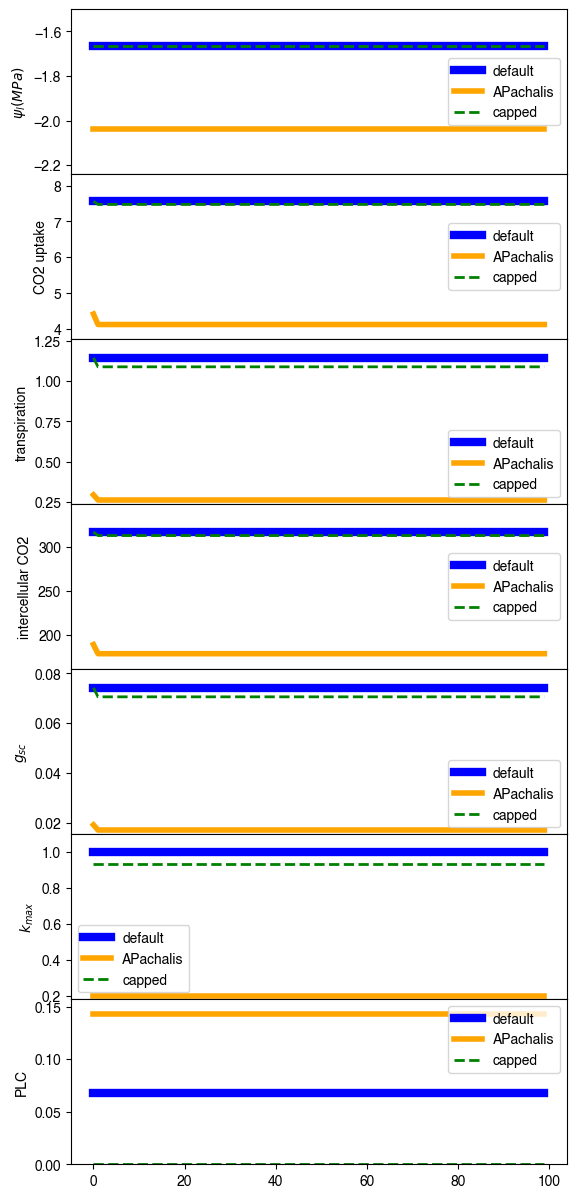

In [16]:

plot_y_labels = ["$\psi_l (MPa)$",
                 "CO2 uptake",
                 "transpiration",
                 "intercellular CO2",
                 "$g_{sc}$",
                 "$k_{max}$",
                 "PLC"]

plot_values = [optimal_leaf_water_potential,
               net_CO2_uptake,
               transpiration_rate,
               intercellular_CO2,
               stomatal_conductance_to_CO2,
               k_max,
               PLC]

# -- plot and format subfigures --
fig, axs = plt.subplots(len(plot_values),1, sharex = True)

for i in range(len(plot_values)):
    for j in range(number_of_models):
        axs[i].plot(time, plot_values[i][j],
                    label = profit_optimisation_model_labels[j], ls = line_styles[j], linewidth = line_sizes[j], c = colours[j])
    axs[i].set_ylabel(plot_y_labels[i])
    axs[i].legend()

    # Set limits
    min_value = np.min(plot_values[i])
    max_value = np.max(plot_values[i])

    min_value -= 0.1*np.absolute(min_value)
    max_value += 0.1*np.absolute(max_value)
    
    axs[i].set_ylim(min_value, max_value)

# -- Format figure --
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_figheight(15)

plt.show()

# Dry down and recovery

Lets repeat the experiment above with a dry down of the soil, before reverting the soil water potential to its original value.

In [17]:
# Reset the conductance models xylem damage.
for current_model in profit_optimisation_models:
    current_model.hydraulic_cost_model.hydraulic_conductance_model.reset_xylem_damage()

# -- setup soil water potential values --
time_steps = 500
soil_water_potentials = np.zeros(time_steps)

soil_water_potentials[0:100] = -0.5 # MPa
soil_water_potentials[100:200] = np.linspace(-0.5,-3.,100) # MPa
soil_water_potentials[200:] = -0.5 # MPa

# -- setup time --
time = [i*time_step_size for i in range(time_steps)]

# -- setup output arrays --
optimal_leaf_water_potential = np.zeros([number_of_models, time_steps])
net_CO2_uptake               = np.zeros([number_of_models, time_steps])
transpiration_rate           = np.zeros([number_of_models, time_steps])
intercellular_CO2            = np.zeros([number_of_models, time_steps])
stomatal_conductance_to_CO2  = np.zeros([number_of_models, time_steps])
k_max                        = np.zeros([number_of_models, time_steps])
k                            = np.zeros((number_of_models, time_steps))
PLC                          = np.zeros([number_of_models, time_steps])

for i in range(number_of_models):
    for j in range(time_steps):
        [optimal_leaf_water_potential[i,j],
         net_CO2_uptake[i,j],
         transpiration_rate[i,j],
         intercellular_CO2[i,j],
         stomatal_conductance_to_CO2[i,j]] = profit_optimisation_models[i].calculate_time_step(time_step_size,
                                                                                               soil_water_potentials[j],
                                                                                               air_temperature,
                                                                                               air_vapour_pressure_deficit,
                                                                                               air_pressure,
                                                                                               atmospheric_CO2_concentration,
                                                                                               intercellular_oxygen,
                                                                                               photosynthetically_active_radiation,
                                                                                               number_of_sample_points)

        k_max[i,j] = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.maximum_conductance
        k[i,j]     = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.conductance(optimal_leaf_water_potential[i,j])

        PLC[i,j] = 1 - k[i,j]/k_max[i,j]

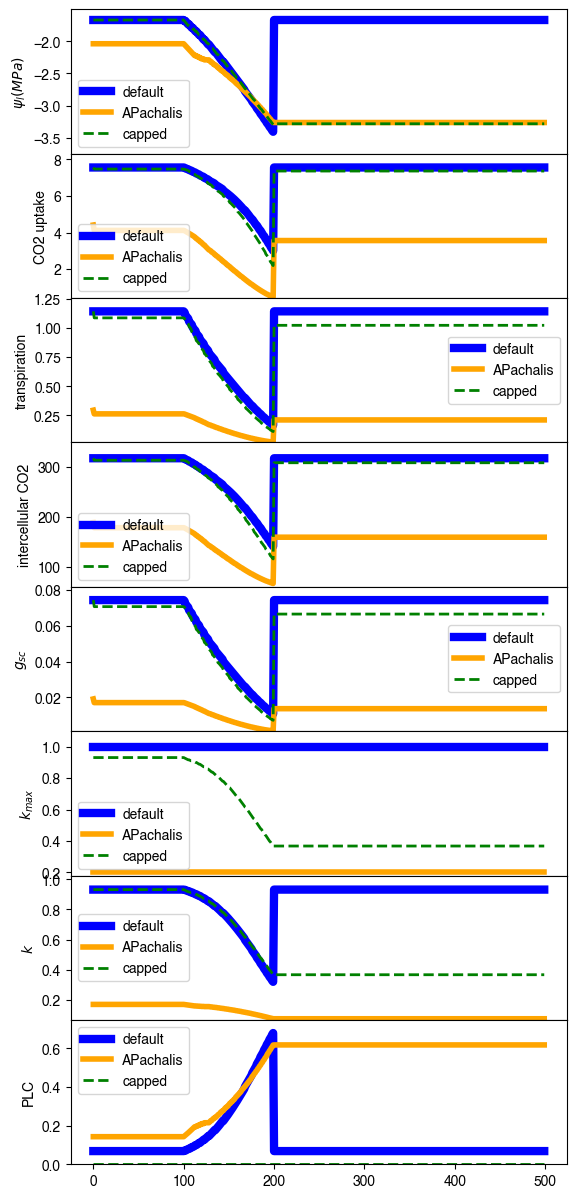

In [18]:

plot_y_labels = ["$\psi_l (MPa)$",
                 "CO2 uptake",
                 "transpiration",
                 "intercellular CO2",
                 "$g_{sc}$",
                 "$k_{max}$",
                 "$k$",
                 "PLC"]

plot_values = [optimal_leaf_water_potential,
               net_CO2_uptake,
               transpiration_rate,
               intercellular_CO2,
               stomatal_conductance_to_CO2,
               k_max,
               k,
               PLC]

# -- plot and format subfigures --
fig, axs = plt.subplots(len(plot_values),1, sharex = True)
for i in range(len(plot_values)):
    for j in range(number_of_models):
        axs[i].plot(time, plot_values[i][j],
                    label = profit_optimisation_model_labels[j], ls = line_styles[j], linewidth = line_sizes[j], c = colours[j])
    axs[i].set_ylabel(plot_y_labels[i])
    axs[i].legend()

    # Set limits
    min_value = np.min(plot_values[i])
    max_value = np.max(plot_values[i])

    min_value -= 0.1*np.absolute(min_value)
    max_value += 0.1*np.absolute(max_value)
    
    axs[i].set_ylim(min_value, max_value)

# -- Format figure --
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_figheight(15)

plt.show()

# Similarities with the capped conductance model

From both this drydown and the previous steady state simulated experiments itis clear that the A.Pachalis model is producing the same results as a simple capped conductance model. At its simplist form the A.Pachalis model treats xylem imparment in the same way as the capped model, xylem conductance being capped at the minimum previous conductance during its lifetime. The point it varies is at a higher level where by growing new xylem that are not yet capped while killing off the older capped xylem. This begs the question as to why the A.Pachalis model doesn't recover after the dry down as we would epect and was shown in [A.Pahchalis et al 2023](https://pubmed.ncbi.nlm.nih.gov/37962234/).

The lack of recovery is due to the behaviour of profit optimisation model when presented with a capped vunrability curve. As can be seen in the first figure plotted below the optimal water potential, when using a capped conductance model, is that at which the conductance would switch from the the capped value to a lower conductance as indicated by the sharp change in hydraulic cost. Plotting the same graph for the A.Pachalis model, the second figure bellow, gives the same responce optimal water potential for the same reason. The result of this choice of conductance is that any new xylem are imediatly capped at this same conductance stopping any recovery from occuring.

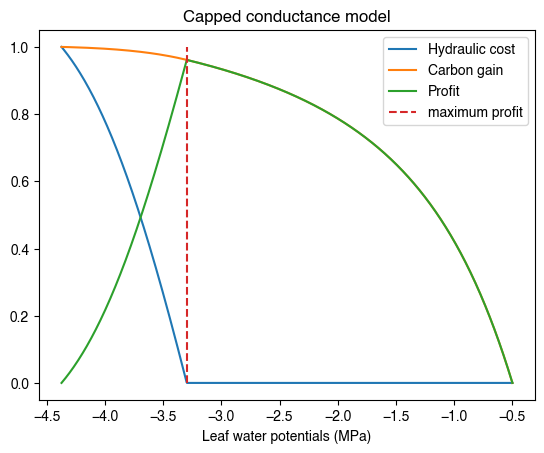

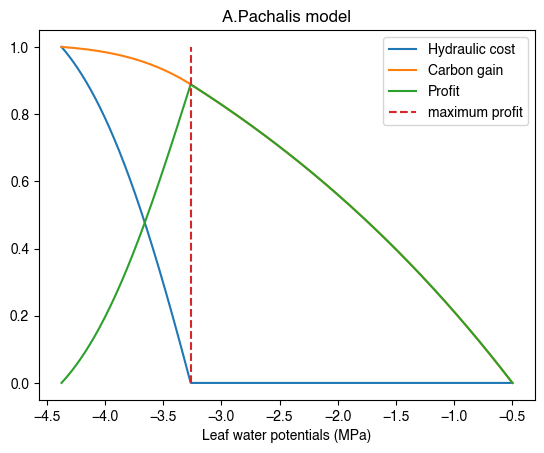

In [19]:
profit_values_cap, carbon_gain_cap, hydraulic_costs_cap, __, __, __, __, water_potentials_cap = \
    capped_profit_optimisation_model.profit_as_a_function_of_leaf_water_potential(soil_water_potential,
                                                                                  air_temperature,
                                                                                  air_vapour_pressure_deficit,
                                                                                  air_pressure,
                                                                                  atmospheric_CO2_concentration,
                                                                                  intercellular_oxygen,
                                                                                  photosynthetically_active_radiation,
                                                                                  number_of_sample_points = 1000)

maximum_profit_id_cap = np.nanargmax(profit_values_cap)
optimal_leaf_water_potential_cap = water_potentials_cap[maximum_profit_id_cap]

plt.plot(water_potentials_cap, hydraulic_costs_cap, label = "Hydraulic cost")
plt.plot(water_potentials_cap, carbon_gain_cap, label = "Carbon gain")
plt.plot(water_potentials_cap, profit_values_cap, label = "Profit")
plt.plot([optimal_leaf_water_potential_cap, optimal_leaf_water_potential_cap], [0,1], linestyle='--', label = "maximum profit")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.title("Capped conductance model")
plt.show()

profit_values_cap, carbon_gain_cap, hydraulic_costs_cap, __, __, __, __, water_potentials_cap = \
    AP_profit_optimisation_model.profit_as_a_function_of_leaf_water_potential(soil_water_potential,
                                                                              air_temperature,
                                                                              air_vapour_pressure_deficit,
                                                                              air_pressure,
                                                                              atmospheric_CO2_concentration,
                                                                              intercellular_oxygen,
                                                                              photosynthetically_active_radiation,
                                                                              number_of_sample_points = 1000)

maximum_profit_id_cap = np.nanargmax(profit_values_cap)
optimal_leaf_water_potential_cap = water_potentials_cap[maximum_profit_id_cap]

plt.plot(water_potentials_cap, hydraulic_costs_cap, label = "Hydraulic cost")
plt.plot(water_potentials_cap, carbon_gain_cap, label = "Carbon gain")
plt.plot(water_potentials_cap, profit_values_cap, label = "Profit")
plt.plot([optimal_leaf_water_potential_cap, optimal_leaf_water_potential_cap], [0,1], linestyle='--', label = "maximum profit")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.title("A.Pachalis model")
plt.show()